In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm, lognorm
from astroML.utils import log_multivariate_gaussian
import emcee
from schwimmbad import MultiPool

rnd = np.random.RandomState(seed=42)  # what else?

$$
y_{\rm true} = a\,x + b + \frac{c}{\sqrt{2 \pi} d} \, \exp{\left(-\frac{(x-x_0)^2}{2 \, d^2}\right)}
$$

In [2]:
def eval_model(a, b, c, d, x0, x):
    return a * x + b + c * norm.pdf(x, loc=x0, scale=d)

In [3]:
N = 16

x0 = rnd.uniform(-1, 1)
x = np.linspace(-5, 5, N)
true_y = eval_model(a=rnd.uniform(-0.1, 0.1),
                    b=rnd.uniform(1, 10),
                    c=rnd.uniform(2, 3),
                    d=rnd.uniform(0.5, 1.),
                    x0=x0,
                    x=x)

y_err = rnd.uniform(0.1, 0.2, size=N)
y = rnd.normal(true_y, y_err)

<ErrorbarContainer object of 3 artists>

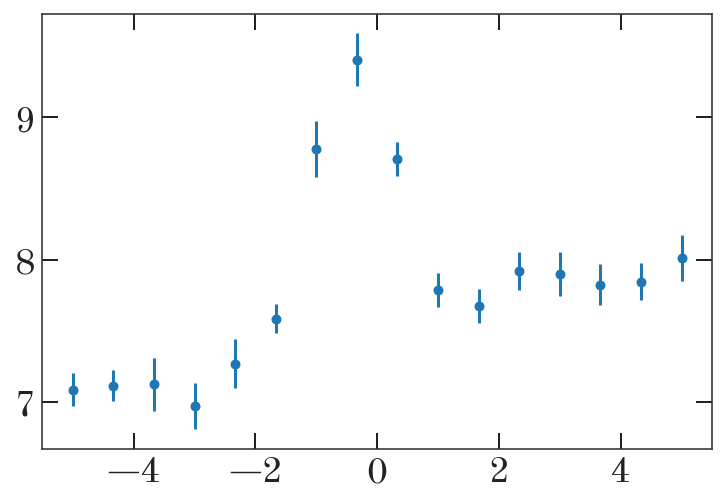

In [4]:
plt.errorbar(x, y, y_err, 
             marker='o', ls='none')

In [5]:
def design_matrix(x0, d, x):
    M = np.stack((x, 
                  np.ones_like(x), 
                  norm.pdf(x, loc=x0, scale=d)), 
                 axis=1)
    return M

In [6]:
C = np.diag(y_err ** 2)
mu = np.array([0., 1, 1])
L = np.diag([0.1, 10, 3]) ** 2

In [7]:
def get_aAbB(y, C, M, mu, L):
    Linv = np.linalg.inv(L)
    Cinv = np.linalg.inv(C)

    b = M @ mu
    B = C + M @ L @ M.T

    Ainv = Linv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    Binv = Cinv - Cinv @ M @ A @ M.T @ Cinv
    
    res = dict()
    res['lnlike'] = log_multivariate_gaussian(y, b, B, Vinv=Binv)
    res['a'] = np.linalg.solve(Ainv, Linv @ mu + M.T @ Cinv @ y)
    res['A'] = A
    res['b'] = b
    res['B'] = B

    return res

In [8]:
def ln_likelihood(p, x, y, C, mu, L):
    ln_d, x0 = p
    d = np.exp(ln_d)
    M = design_matrix(x0, d, x)
    res = get_aAbB(y, C, M, mu, L)
    return res['lnlike']

def ln_prior(p):
    ln_d, x0 = p
    d = np.exp(ln_d)
    lp = norm.logpdf(ln_d, 0, 1.5)
    lp += norm.logpdf(x0, 0, 1)
    return lp

def ln_posterior(p, x, y, C, mu, L):
    lp = ln_prior(p)
    ll = ln_likelihood(p, x, y, C, mu, L)
    if not np.isfinite(lp) or not np.isfinite(ll):
        print(lp, ll)
    return lp + ll

In [9]:
nwalkers = 64
ndim = 2

In [10]:
p0 = np.stack((rnd.normal(-0.5, 1e-3, size=nwalkers),
               rnd.normal(0, 0.1, size=nwalkers)),
              axis=1)

In [11]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior,
                                    pool=pool,
                                    args=(x, y, C, mu, L))
    
    pos, *_ = sampler.run_mcmc(p0, 1000, progress=True)
    sampler.reset()
    pos, *_ = sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████| 10000/10000 [01:50<00:00, 90.18it/s]


In [18]:
sampler.acor

array([31.48801742, 31.31071554])

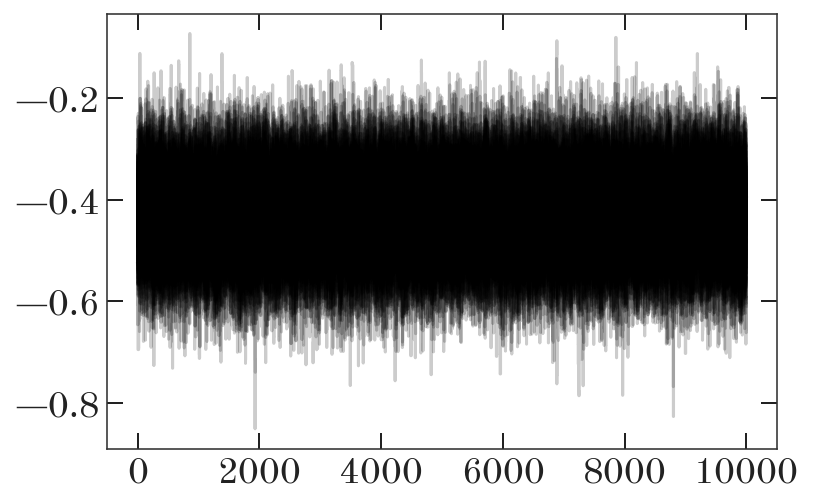

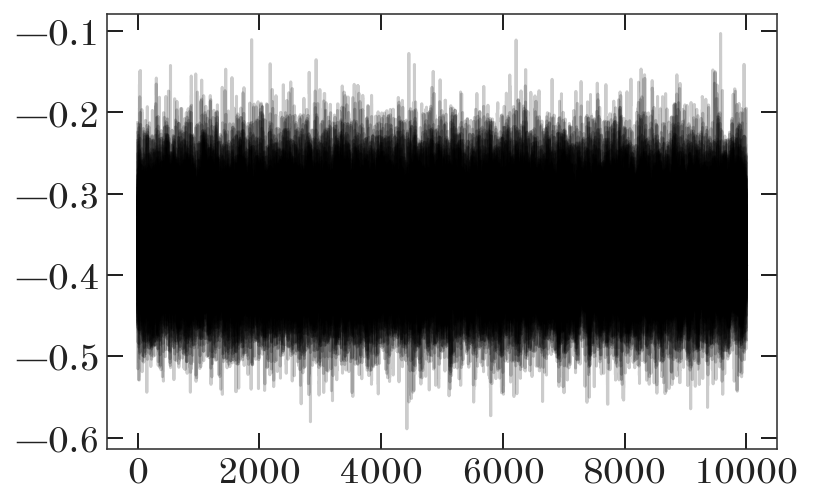

In [13]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, marker='', drawstyle='steps-mid', 
                 alpha=0.2, color='k')

In [217]:
def make_full_sample(p, x, y, C, mu, L):
    d, x0 = p
    M = design_matrix(x0, d, x)
    res = get_aAbB(y, C, M, mu, L)
    linear_sample = np.random.multivariate_normal(res['a'], res['A'])
    return np.concatenate((linear_sample, p))

In [224]:
n_prior_samples = 100_000
prior_samples = np.stack((rnd.lognormal(0, 1.5, size=n_prior_samples),
                          rnd.uniform(-1, 1, size=n_prior_samples)),
                         axis=1)

In [225]:
marg_lnlikes = np.array([ln_likelihood(p, x, y, C, mu, L) 
                         for p in prior_samples])

In [226]:
mask = np.exp(marg_lnlikes - marg_lnlikes.max()) > rnd.uniform(size=n_prior_samples)
mask.sum()

289

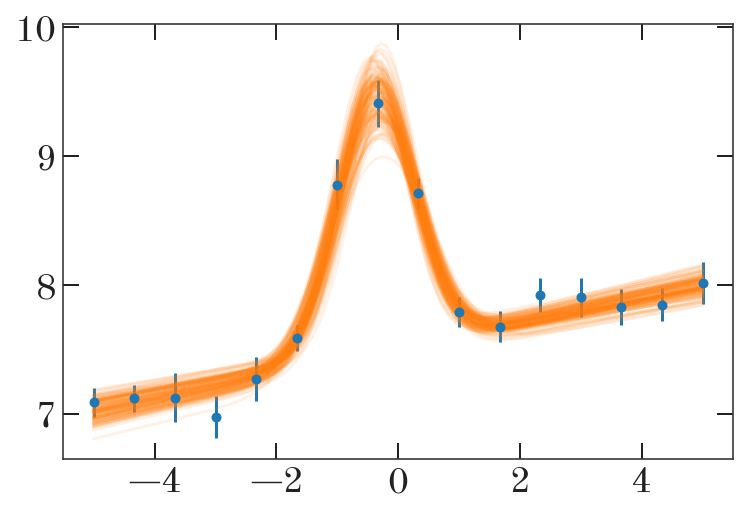

In [232]:
plt.errorbar(x, y, y_err, 
             marker='o', ls='none')

grid_x = np.linspace(-5, 5, 128)

for p in prior_samples[mask][:128]:
    full_sample = make_full_sample(p, x, y, C, mu, L)
    plt.plot(grid_x, eval_model(*full_sample, x=grid_x),
             marker='', alpha=0.1, color='tab:orange')